In [1]:
import tensorflow as tf
from tensorflow import keras
import resnet_V2
import matplotlib.pyplot as plt
from tqdm import tqdm

2022-01-05 14:23:16.071280: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
input_size = 256
batch_size = 32

ae = resnet_V2.ResNetAE()

2022-01-05 14:23:17.052035: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-05 14:23:17.108405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 14:23:17.108899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-05 14:23:17.108913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-05 14:23:17.110189: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-05 14:23:17.111102: I tensorflow/stream_executor/platform/default/

In [3]:
def scaling(x):
    x = tf.cast(x, tf.float32) / 255.
    return x

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    './DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='training',
    seed=42)

test_ds = keras.preprocessing.image_dataset_from_directory(
    './DOG',
    image_size=(input_size, input_size),
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.01,
    subset='validation',
    seed=42)

train_ds = train_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(scaling).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 15348 files belonging to 157 classes.
Using 15195 files for training.
Found 15348 files belonging to 157 classes.
Using 153 files for validation.


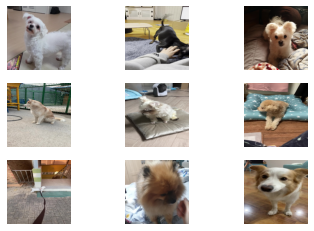

In [5]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

In [6]:
mse = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, model, optimizer):
    with tf.GradientTape() as tape:
        recon = model(x)
        loss = mse(x, recon)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [7]:
def save_image(model, sample, epoch):
    sample = ae(sample)
    for i in range(4):
        ax = plt.subplot(2, 2, i +1)
        plt.imshow(sample[i].numpy())
        plt.axis('off')
        
    plt.savefig('./train_image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.clf()
    plt.close()

In [8]:
sample = None
for t in test_ds.take(1):
    sample = t
sample.shape

TensorShape([32, 256, 256, 3])

In [9]:
optimizer = keras.optimizers.Adam()
epochs =100

ckpt_path = './ckpt/model_'
best_loss = 1
best_epoch = 0

for epoch in range(1, epochs + 1):
    for train_x in tqdm(train_ds, desc=str(epoch)):
        train_step(train_x, ae, optimizer)
        
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_ds:
        test_recon = ae(test_x)
        loss(mse(test_x, test_recon))
        
    if loss.result() < best_loss:
        best_loss = loss.result()
        best_epoch = epoch
        
    print('epoch {} test loss {}'.format(epoch, loss.result()))
    print('best loss {} best epoch {}'.format(best_loss, best_epoch))
    print()
    
    ae.save_weights(ckpt_path + str(epoch))
    save_image(ae, sample, epoch)

1:   0%|                                                | 0/475 [00:00<?, ?it/s]2022-01-05 14:23:46.965936: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-05 14:23:47.111995: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
1: 100%|██████████████████████████████████████| 475/475 [04:43<00:00,  1.67it/s]


epoch 1 test loss 0.01608356274664402
best loss 0.01608356274664402 best epoch 1



2: 100%|██████████████████████████████████████| 475/475 [04:26<00:00,  1.79it/s]


epoch 2 test loss 0.011153409257531166
best loss 0.011153409257531166 best epoch 2



3: 100%|██████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 3 test loss 0.009524503722786903
best loss 0.009524503722786903 best epoch 3



4: 100%|██████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 4 test loss 0.00875733233988285
best loss 0.00875733233988285 best epoch 4



5: 100%|██████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 5 test loss 0.008460506796836853
best loss 0.008460506796836853 best epoch 5



6: 100%|██████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 6 test loss 0.008187174797058105
best loss 0.008187174797058105 best epoch 6



7: 100%|██████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 7 test loss 0.008077281527221203
best loss 0.008077281527221203 best epoch 7



8: 100%|██████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 8 test loss 0.007796470075845718
best loss 0.007796470075845718 best epoch 8



9: 100%|██████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 9 test loss 0.007969855330884457
best loss 0.007796470075845718 best epoch 8



10: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 10 test loss 0.007513169199228287
best loss 0.007513169199228287 best epoch 10



11: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 11 test loss 0.007793784141540527
best loss 0.007513169199228287 best epoch 10



12: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 12 test loss 0.007575418800115585
best loss 0.007513169199228287 best epoch 10



13: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 13 test loss 0.007339167408645153
best loss 0.007339167408645153 best epoch 13



14: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 14 test loss 0.007234106305986643
best loss 0.007234106305986643 best epoch 14



15: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 15 test loss 0.007351110689342022
best loss 0.007234106305986643 best epoch 14



16: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 16 test loss 0.007511931471526623
best loss 0.007234106305986643 best epoch 14



17: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 17 test loss 0.0073649040423333645
best loss 0.007234106305986643 best epoch 14



18: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 18 test loss 0.007125426083803177
best loss 0.007125426083803177 best epoch 18



19: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 19 test loss 0.007146293763071299
best loss 0.007125426083803177 best epoch 18



20: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 20 test loss 0.007106083445250988
best loss 0.007106083445250988 best epoch 20



21: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 21 test loss 0.006999115459620953
best loss 0.006999115459620953 best epoch 21



22: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 22 test loss 0.007202366832643747
best loss 0.006999115459620953 best epoch 21



23: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 23 test loss 0.007068154402077198
best loss 0.006999115459620953 best epoch 21



24: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 24 test loss 0.007134666200727224
best loss 0.006999115459620953 best epoch 21



25: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 25 test loss 0.007118357811123133
best loss 0.006999115459620953 best epoch 21



26: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 26 test loss 0.007149131037294865
best loss 0.006999115459620953 best epoch 21



27: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 27 test loss 0.006922970525920391
best loss 0.006922970525920391 best epoch 27



28: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 28 test loss 0.00700691994279623
best loss 0.006922970525920391 best epoch 27



29: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 29 test loss 0.006977833807468414
best loss 0.006922970525920391 best epoch 27



30: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.79it/s]


epoch 30 test loss 0.006981908343732357
best loss 0.006922970525920391 best epoch 27



31: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.79it/s]


epoch 31 test loss 0.007073575165122747
best loss 0.006922970525920391 best epoch 27



32: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 32 test loss 0.006908525712788105
best loss 0.006908525712788105 best epoch 32



33: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 33 test loss 0.006888316012918949
best loss 0.006888316012918949 best epoch 33



34: 100%|█████████████████████████████████████| 475/475 [04:26<00:00,  1.78it/s]


epoch 34 test loss 0.006983309052884579
best loss 0.006888316012918949 best epoch 33



35: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 35 test loss 0.006930201314389706
best loss 0.006888316012918949 best epoch 33



36: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 36 test loss 0.006963418330997229
best loss 0.006888316012918949 best epoch 33



37: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 37 test loss 0.006812483072280884
best loss 0.006812483072280884 best epoch 37



38: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 38 test loss 0.006976918317377567
best loss 0.006812483072280884 best epoch 37



39: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 39 test loss 0.006887058727443218
best loss 0.006812483072280884 best epoch 37



40: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 40 test loss 0.006824204232543707
best loss 0.006812483072280884 best epoch 37



41: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 41 test loss 0.006903473287820816
best loss 0.006812483072280884 best epoch 37



42: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 42 test loss 0.006824990268796682
best loss 0.006812483072280884 best epoch 37



43: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 43 test loss 0.006808108650147915
best loss 0.006808108650147915 best epoch 43



44: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 44 test loss 0.0068994187749922276
best loss 0.006808108650147915 best epoch 43



45: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 45 test loss 0.0069290511310100555
best loss 0.006808108650147915 best epoch 43



46: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 46 test loss 0.006913150195032358
best loss 0.006808108650147915 best epoch 43



47: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 47 test loss 0.0069044968113303185
best loss 0.006808108650147915 best epoch 43



48: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 48 test loss 0.006830753292888403
best loss 0.006808108650147915 best epoch 43



49: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 49 test loss 0.006758315023034811
best loss 0.006758315023034811 best epoch 49



50: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 50 test loss 0.0068706972524523735
best loss 0.006758315023034811 best epoch 49



51: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 51 test loss 0.006665048189461231
best loss 0.006665048189461231 best epoch 51



52: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 52 test loss 0.0067094312980771065
best loss 0.006665048189461231 best epoch 51



53: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 53 test loss 0.006781592965126038
best loss 0.006665048189461231 best epoch 51



54: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 54 test loss 0.006766221020370722
best loss 0.006665048189461231 best epoch 51



55: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 55 test loss 0.006784886121749878
best loss 0.006665048189461231 best epoch 51



56: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 56 test loss 0.006762963719666004
best loss 0.006665048189461231 best epoch 51



57: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 57 test loss 0.006800360046327114
best loss 0.006665048189461231 best epoch 51



58: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 58 test loss 0.0068244352005422115
best loss 0.006665048189461231 best epoch 51



59: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 59 test loss 0.006784147582948208
best loss 0.006665048189461231 best epoch 51



60: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 60 test loss 0.006740919314324856
best loss 0.006665048189461231 best epoch 51



61: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 61 test loss 0.00659633195027709
best loss 0.00659633195027709 best epoch 61



62: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 62 test loss 0.006983649916946888
best loss 0.00659633195027709 best epoch 61



63: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 63 test loss 0.006907361559569836
best loss 0.00659633195027709 best epoch 61



64: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 64 test loss 0.006787440273910761
best loss 0.00659633195027709 best epoch 61



65: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 65 test loss 0.006677868776023388
best loss 0.00659633195027709 best epoch 61



66: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 66 test loss 0.006811066064983606
best loss 0.00659633195027709 best epoch 61



67: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 67 test loss 0.006676577031612396
best loss 0.00659633195027709 best epoch 61



68: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 68 test loss 0.006793101318180561
best loss 0.00659633195027709 best epoch 61



69: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 69 test loss 0.006730183959007263
best loss 0.00659633195027709 best epoch 61



70: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 70 test loss 0.0067540304735302925
best loss 0.00659633195027709 best epoch 61



71: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 71 test loss 0.006827636156231165
best loss 0.00659633195027709 best epoch 61



72: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 72 test loss 0.006707972381263971
best loss 0.00659633195027709 best epoch 61



73: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 73 test loss 0.006654647178947926
best loss 0.00659633195027709 best epoch 61



74: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 74 test loss 0.006725826300680637
best loss 0.00659633195027709 best epoch 61



75: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 75 test loss 0.006715708877891302
best loss 0.00659633195027709 best epoch 61



76: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 76 test loss 0.006728814449161291
best loss 0.00659633195027709 best epoch 61



77: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 77 test loss 0.006658464670181274
best loss 0.00659633195027709 best epoch 61



78: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 78 test loss 0.0067476509138941765
best loss 0.00659633195027709 best epoch 61



79: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 79 test loss 0.006783629767596722
best loss 0.00659633195027709 best epoch 61



80: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 80 test loss 0.006714705377817154
best loss 0.00659633195027709 best epoch 61



81: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 81 test loss 0.006803104188293219
best loss 0.00659633195027709 best epoch 61



82: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 82 test loss 0.0067818984389305115
best loss 0.00659633195027709 best epoch 61



83: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 83 test loss 0.006673268973827362
best loss 0.00659633195027709 best epoch 61



84: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 84 test loss 0.006761584430932999
best loss 0.00659633195027709 best epoch 61



85: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 85 test loss 0.0067567406222224236
best loss 0.00659633195027709 best epoch 61



86: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 86 test loss 0.006763072218745947
best loss 0.00659633195027709 best epoch 61



87: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 87 test loss 0.006711523048579693
best loss 0.00659633195027709 best epoch 61



88: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 88 test loss 0.006764233112335205
best loss 0.00659633195027709 best epoch 61



89: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 89 test loss 0.006701451726257801
best loss 0.00659633195027709 best epoch 61



90: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 90 test loss 0.0066747344098985195
best loss 0.00659633195027709 best epoch 61



91: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 91 test loss 0.0067451708018779755
best loss 0.00659633195027709 best epoch 61



92: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 92 test loss 0.0069377184845507145
best loss 0.00659633195027709 best epoch 61



93: 100%|█████████████████████████████████████| 475/475 [04:25<00:00,  1.79it/s]


epoch 93 test loss 0.006682025734335184
best loss 0.00659633195027709 best epoch 61



94: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 94 test loss 0.006688869092613459
best loss 0.00659633195027709 best epoch 61



95: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 95 test loss 0.0067985630594193935
best loss 0.00659633195027709 best epoch 61



96: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 96 test loss 0.006738430354744196
best loss 0.00659633195027709 best epoch 61



97: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 97 test loss 0.0066237421706318855
best loss 0.00659633195027709 best epoch 61



98: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 98 test loss 0.006731645669788122
best loss 0.00659633195027709 best epoch 61



99: 100%|█████████████████████████████████████| 475/475 [04:24<00:00,  1.79it/s]


epoch 99 test loss 0.006769829895347357
best loss 0.00659633195027709 best epoch 61



100: 100%|████████████████████████████████████| 475/475 [04:24<00:00,  1.80it/s]


epoch 100 test loss 0.006774925626814365
best loss 0.00659633195027709 best epoch 61



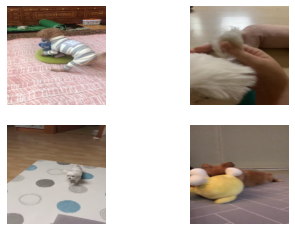

In [10]:
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(sample[i].numpy())
    plt.axis('off')

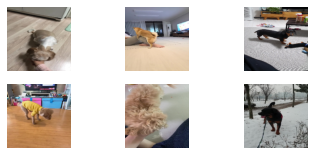

In [11]:
for images in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

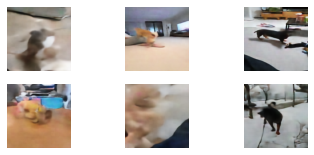

In [12]:
recon = ae(images)
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(recon[i].numpy())
    plt.axis('off')